In [0]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split

In [2]:
#Loading Dataset
df=pd.read_csv("bank-full.csv",sep=';')
#printing the head of the Dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [0]:
#Creating Dummy Variables

df['y'] = df['y'].map({'yes': 1, 'no': 0})
df['default']=df['default'].map({'yes': 1, 'no': 0})
df['housing']=df['housing'].map({'yes': 1, 'no': 0})
df['loan']=df['loan'].map({'yes': 1, 'no': 0})
df_marital = pd.get_dummies(df['marital'])
df['married'] = df_marital['married']
df['divorced'] = df_marital['divorced']
df_education = pd.get_dummies(df['education'])
df['tertiary'] = df_education['tertiary']
df['secondary'] = df_education['secondary']

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,married,divorced,tertiary,secondary
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0,1,0,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0,0,0,0,1
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0,1,0,0,1
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0,1,0,0,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0,0,0,0,0


In [0]:
cols = ['age', 'default', 'balance', 'housing',
       'loan','duration', 'campaign', 'pdays',
       'previous', 'y', 'married', 'divorced','tertiary',
       'secondary']
df = df[cols]

In [6]:
df.head()

,age,default,balance,housing,loan,duration,campaign,pdays,previous,y,married,divorced,tertiary,secondary
0,58,0,2143,1,0,261,1,-1,0,0,1,0,1,0
1,44,0,29,1,0,151,1,-1,0,0,0,0,0,1
2,33,0,2,1,1,76,1,-1,0,0,1,0,0,1
3,47,0,1506,1,0,92,1,-1,0,0,1,0,0,0
4,33,0,1,0,0,198,1,-1,0,0,0,0,0,0


In [0]:
#Splitting x and y
y=df['y'].values
X=df.drop(['y'], axis=1).values
#X=df[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',]].values
#Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=100)

In [0]:
def featureNormalize(X):
    X_norm = X
    mu    = np.zeros((1, X.shape[1]))
    sigma = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
      mu[:,i] = np.mean(X[:,i])
      sigma[:,i] = np.std(X[:,i])
      X_norm[:,i] = (X[:,i] - float(mu[:,i]))/float(sigma[:,i])
    return X_norm, mu, sigma

In [0]:
X_norm, mu, sigma = featureNormalize(X_train)
X_train = X_norm
X_test = (X_test - mu)/sigma

In [10]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(31647, 13) (31647,)
(13564, 13) (13564,)


In [0]:
X_train_flatten  = X_train.reshape(X_train.shape[0],-1).T
y_train_flatten = y_train.reshape(y_train.shape[0],-1).T
X_test_flatten  = X_test.reshape(X_test.shape[0],-1).T
y_test_flatten = y_test.reshape(y_test.shape[0],-1).T

In [0]:
X_train = X_train_flatten
X_test = X_test_flatten
y_train = y_train_flatten
y_test = y_test_flatten

In [13]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(13, 31647) (1, 31647)
(13, 13564) (1, 13564)


In [0]:
@tf.function
def create_placeholders(n_x, n_y):
  X = tf.placeholder(tf.float32,[n_x,None]) # Since we have 27 features as input
  y = tf.placeholder(tf.float32,[n_y,None])  # Since we have 1 outut labels
  return X,y

In [0]:
def initialize_parameters(layer_dims):
  tf.set_random_seed(1)  
  parameters = {}
  L = len(layer_dims)       

  for l in range(1, L):
    #Intializing Parameters
    parameters['W' + str(l)] = tf.get_variable('W' + str(l) ,shape = [layer_dims[l],layer_dims[l-1]],initializer =  tf.initializers.glorot_normal())
    parameters['b' + str(l)] = tf.get_variable('b' + str(l) ,shape = [layer_dims[l],1],initializer = tf.zeros_initializer)
 
  return parameters

In [0]:
@tf.function
def relu(Z):  
    A = tf.nn.relu(Z)
    cache = Z 
    return A, cache

In [0]:
@tf.function
def sigmoid(Z):
    A = tf.nn.sigmoid(Z)
    cache = Z
    
    return A, cache

In [0]:
def linear_forward(A, W, b):
    
    Z = tf.matmul(W,A) + b

    cache = (A, W, b)
    
    return Z, cache

In [0]:
@tf.function
def linear_activation_forward(A_prev, W, b, activation):

  if activation == "sigmoid":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = sigmoid(Z)

  elif activation == "relu":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = relu(Z)

  cache = (linear_cache, activation_cache)

  return A, cache

In [0]:
@tf.function
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    
    #assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [0]:
@tf.function
def compute_cost(AL, Y):
    logits = tf.transpose(AL)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.math.squared_difference(logits,labels))
    return cost

In [0]:
### CONSTANTS ###
layers_dims = [13, 20, 10, 5, 1] #  4-layer model

In [23]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(13,1)
    parameters = initialize_parameters(layers_dims)
    AL, caches = L_model_forward(X, parameters)
    cost = compute_cost(AL, Y)
    print("cost = " + str(cost))
    print(parameters)

cost = Tensor("PartitionedCall_2:0", shape=(), dtype=float32)
{'W1': <tf.Variable 'W1:0' shape=(20, 13) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(20, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(10, 20) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(10, 1) dtype=float32_ref>, 'W3': <tf.Variable 'W3:0' shape=(5, 10) dtype=float32_ref>, 'b3': <tf.Variable 'b3:0' shape=(5, 1) dtype=float32_ref>, 'W4': <tf.Variable 'W4:0' shape=(1, 5) dtype=float32_ref>, 'b4': <tf.Variable 'b4:0' shape=(1, 1) dtype=float32_ref>}


In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
   
    m = X.shape[1]                 # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def model(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.01,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 30                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    
    # Forward propagation
    AL, caches = L_model_forward(X, parameters)
    
    # Cost function
    cost = compute_cost(AL, Y)
    
    # Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
          
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        # plt.plot(np.squeeze(costs))
        # plt.ylabel('cost')
        # plt.xlabel('iterations (per tens)')
        # plt.title("Learning rate =" + str(learning_rate))
        # plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        predicted = AL

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.round(predicted), Y)

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        Training_Accuracy = accuracy.eval({X: X_train, Y: Y_train})
        Testing_Accuracy  = accuracy.eval({X: X_test, Y: Y_test})
        print ("Train Accuracy:", Training_Accuracy)
        print ("Test Accuracy:", Testing_Accuracy)
        
        return parameters, costs, Training_Accuracy, Testing_Accuracy

In [26]:
### CONSTANTS ###
layers_dims = [13, 20, 10, 5, 1] #  3-layer hidden model
batches = [100,250,500,2000,5000,10000]
cost_dict=dict()
train_acc = []
test_acc = []
for batch in batches:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = 500,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dims)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.89695704
Test Accuracy: 0.8806399
Parameters have been trained!
Train Accuracy: 0.8988846
Test Accuracy: 0.8661899
Parameters have been trained!
Train Accuracy: 0.8989478
Test Accuracy: 0.8800501
Parameters have been trained!
Train Accuracy: 0.8988846
Test Accuracy: 0.8793866
Parameters have been trained!
Train Accuracy: 0.8995165
Test Accuracy: 0.8758478
Parameters have been trained!
Train Accuracy: 0.8982842
Test Accuracy: 0.8806399


In [27]:
df1 = pd.DataFrame(
    {'MiniBatch Size': batches,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df2 = pd.DataFrame(
    {'MiniBatch Size': batches,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_mini = pd.concat([df1, df2],sort=False)
df_mini['Accuracy'] = (df_mini['Accuracy'] * 100).round(2)
df_mini

,MiniBatch Size,Acc,Accuracy
0,100,TrainingAccuracy,89.70
1,250,TrainingAccuracy,89.89
2,500,TrainingAccuracy,89.89
3,2000,TrainingAccuracy,89.89
4,5000,TrainingAccuracy,89.95
5,10000,TrainingAccuracy,89.83
0,100,TestingAccuracy,88.06
1,250,TestingAccuracy,86.62
2,500,TestingAccuracy,88.01
3,2000,TestingAccuracy,87.94


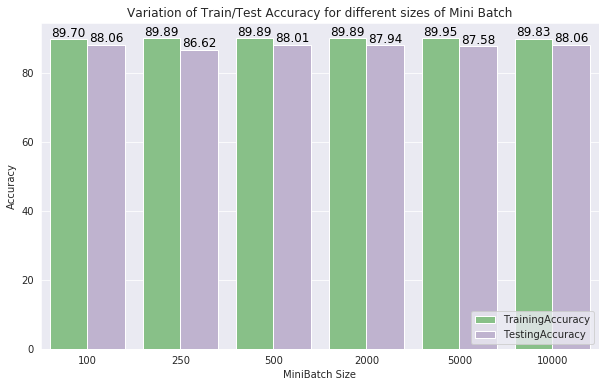

In [28]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="MiniBatch Size", y="Accuracy", hue="Acc",palette="Accent", data=df_mini)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different sizes of Mini Batch')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_mini.png",dpi=150)

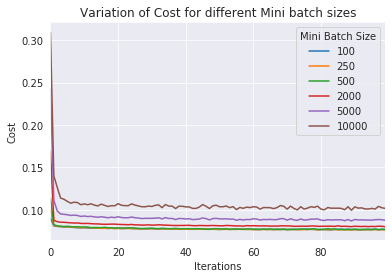

In [29]:
cost_df = pd.DataFrame(cost_dict)
cost_df.plot()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Variation of Cost for different Mini batch sizes")
plt.legend(title='Mini Batch Size')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.savefig("output_line.png",dpi=150)
plt.show()

In [31]:
### CONSTANTS ###
layers_dims = [[13, 20, 10, 5, 1],
               [13,200,100,50,1],
               [13,500,250,100,1],
               [13,1000,500,250,1]]#  4-layer hidden model
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
for layers_dim in layers_dims:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = 500,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dim)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.9012545
Test Accuracy: 0.86596876
Parameters have been trained!
Train Accuracy: 0.91013366
Test Accuracy: 0.8835152
Parameters have been trained!
Train Accuracy: 0.8827693
Test Accuracy: 0.8835889
Parameters have been trained!
Train Accuracy: 0.8827693
Test Accuracy: 0.8835889


In [0]:
df11 = pd.DataFrame(
    {'Accuracy': 'TrainingAccuracy',
     'Accuracy_val': train_acc
    })
df11["Layer number"] = df11.index + 1
df11[['i/p','HL1','HL2','HL3','o/p']] = pd.DataFrame(layers_dims)

df21 = pd.DataFrame(
    {'Accuracy': 'TestingAccuracy',
     'Accuracy_val': test_acc
    })
df21["Layer number"] = df21.index + 1
df21[['i/p','HL1','HL2','HL3','o/p']] = pd.DataFrame(layers_dims)

df_broad = pd.concat([df11, df21],sort=False)
df_broad['Accuracy_val'] = (df_broad['Accuracy_val'] * 100).round(2)

df_broad = df_broad[['Layer number', 'i/p', 'HL1', 'HL2', 'HL3','o/p','Accuracy', 'Accuracy_val']]

In [34]:
df_broad

,Layer number,i/p,HL1,HL2,HL3,o/p,Accuracy,Accuracy_val
0,1,13,20,10,5,1,TrainingAccuracy,90.13
1,2,13,200,100,50,1,TrainingAccuracy,91.01
2,3,13,500,250,100,1,TrainingAccuracy,88.28
3,4,13,1000,500,250,1,TrainingAccuracy,88.28
0,1,13,20,10,5,1,TestingAccuracy,86.60
1,2,13,200,100,50,1,TestingAccuracy,88.35
2,3,13,500,250,100,1,TestingAccuracy,88.36
3,4,13,1000,500,250,1,TestingAccuracy,88.36


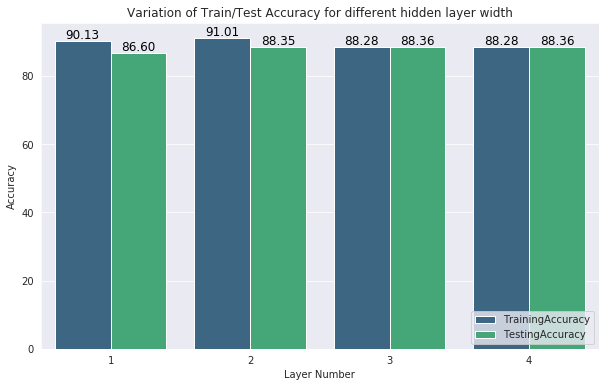

In [38]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Layer number", y="Accuracy_val", hue="Accuracy",palette='viridis', data=df_broad)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different hidden layer width')
ax.set(xlabel='Layer Number', ylabel='Accuracy')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_broad.png",dpi=150)

In [35]:
### CONSTANTS ###
#Varying Number of Epochs
layers_dims = [13, 20, 10, 5, 1]#  4-layer hidden model
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
num_epochs = [50,100,250,500,750,1000,2000,3000]
for num_epoch in num_epochs:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = num_epoch,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dims)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.8939552
Test Accuracy: 0.888381
Parameters have been trained!
Train Accuracy: 0.8958195
Test Accuracy: 0.88882333
Parameters have been trained!
Train Accuracy: 0.898695
Test Accuracy: 0.8829254
Parameters have been trained!
Train Accuracy: 0.9012545
Test Accuracy: 0.86596876
Parameters have been trained!
Train Accuracy: 0.90093845
Test Accuracy: 0.8382483
Parameters have been trained!
Train Accuracy: 0.9012229
Test Accuracy: 0.8229136
Parameters have been trained!
Train Accuracy: 0.9008753
Test Accuracy: 0.85129756
Parameters have been trained!
Train Accuracy: 0.9022972
Test Accuracy: 0.8547626


In [0]:
df31 = pd.DataFrame(
    {'No. of Epochs': num_epochs,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df32 = pd.DataFrame(
    {'No. of Epochs': num_epochs,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_epoch = pd.concat([df31, df32],sort=False)
df_epoch['Accuracy'] = (df_epoch['Accuracy'] * 100).round(2)

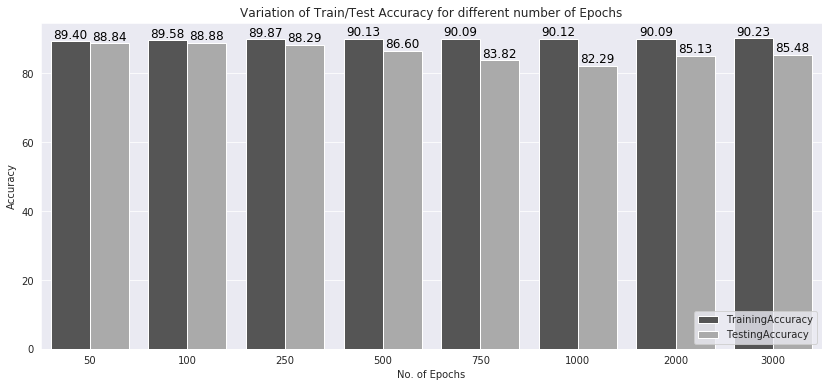

In [37]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(14,6))
ax = sns.barplot(x="No. of Epochs", y="Accuracy", hue="Acc",palette="gist_gray", data=df_epoch)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different number of Epochs')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_epoch.png",dpi=150)

In [39]:
### CONSTANTS ###
layers_dims = [[13,20, 10, 5, 1],
               [13,30,20,10,5,1],
               [13,30,25,20,10,5,1],
               [13,35,30,25,20,10,5,1],
               [13,40,35,30,25,20,10,5,1]]
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
for layers_dim in layers_dims:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = 500,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dim)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.9012545
Test Accuracy: 0.86596876
Parameters have been trained!
Train Accuracy: 0.9046987
Test Accuracy: 0.872309
Parameters have been trained!
Train Accuracy: 0.90548867
Test Accuracy: 0.8832203
Parameters have been trained!
Train Accuracy: 0.9060574
Test Accuracy: 0.87990266
Parameters have been trained!
Train Accuracy: 0.9056151
Test Accuracy: 0.8823356


In [0]:
no_of_hidden_layers=[3,4,5,6,7]
df41 = pd.DataFrame(
    {'no_of_hidden_layers' : no_of_hidden_layers,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df42 = pd.DataFrame(
    {'no_of_hidden_layers' : no_of_hidden_layers,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_hidden = pd.concat([df41, df42],sort=False)
df_hidden['Accuracy'] = (df_hidden['Accuracy'] * 100).round(2)

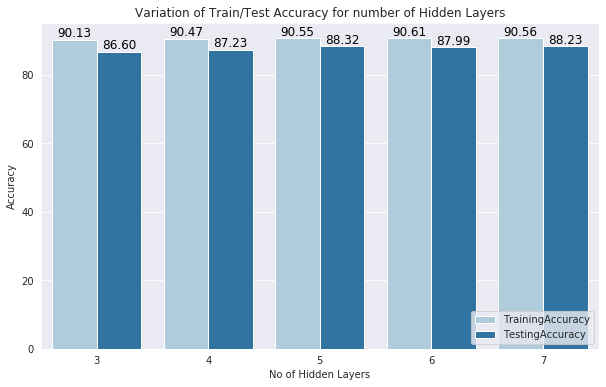

In [41]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="no_of_hidden_layers", y="Accuracy", hue="Acc",palette="Paired", data=df_hidden)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for number of Hidden Layers')
ax.set(xlabel='No of Hidden Layers', ylabel='Accuracy')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_hidden.png",dpi=150)

In [44]:
#Varying Learning Rates
layers_dims = [13, 20, 10, 5, 1]#  4-layer hidden model
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
num_epochs = 500
learning_rates = [0.5,0.1,0.05,0.01,0.005,0.001]
for learning_rate in learning_rates:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = learning_rate,num_epochs = num_epoch,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dims)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.8827693
Test Accuracy: 0.8835889
Parameters have been trained!
Train Accuracy: 0.88472843
Test Accuracy: 0.8442937
Parameters have been trained!
Train Accuracy: 0.89019495
Test Accuracy: 0.87444705
Parameters have been trained!
Train Accuracy: 0.9022972
Test Accuracy: 0.8547626
Parameters have been trained!
Train Accuracy: 0.902234
Test Accuracy: 0.88344145
Parameters have been trained!
Train Accuracy: 0.9006541
Test Accuracy: 0.8459157


In [0]:
df51 = pd.DataFrame(
    {'Learning Rate' : learning_rates,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df52 = pd.DataFrame(
    {'Learning Rate' : learning_rates,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_learning_rate = pd.concat([df51, df52],sort=False).reset_index(drop=True)
df_learning_rate['Accuracy'] = (df_learning_rate['Accuracy'] * 100).round(2)

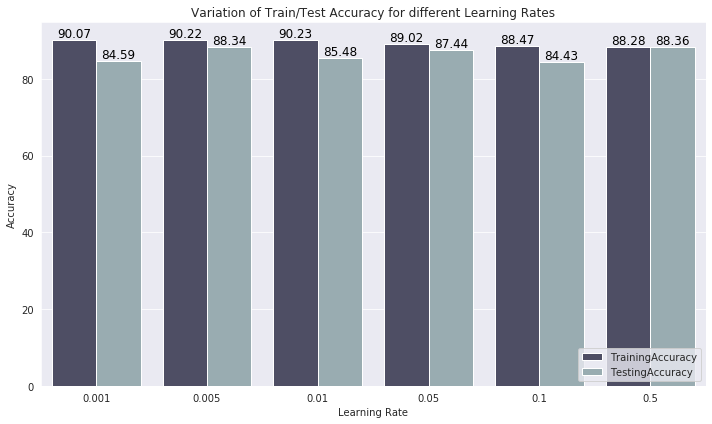

In [46]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Learning Rate", y="Accuracy", hue="Acc",palette="bone", data=df_learning_rate)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different Learning Rates')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.tight_layout()
plt.savefig("output_learning_rate.png",dpi=150)